In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def where_value(value, array):
    """
        Function that returns the indice of a value in a !!! sorted !!! array.
        Essentially a dichotomy (bisection in english).
        It returns indice for which :
        array[indice] < value <=  array[indice+1]
        Returns -1 if value is out of bounds.

        Parameters :
        ------------
        value : [float]
            Value to find in the array.

        array : [array]
            Array in which to look.

        Returns :
        ---------
        indice : [int]
            The indice where the value was found in the array.
    """
    imin = 0
    imax = len(array)-1
    if(value < array[0] or value > array[-1]):
        print("[Warning] in where_value : value is out of range of the array, indice returned : -1")
        indice = -1
    else:
        jj = 0
        while True:
            if (jj > 100000):
                print("[Error] in where_value : looping over 100000 times, aborting.")
                print("[Error] in where_value : imax, imin, j = ", imax, imin, j)
                break
            j = int((imin + imax)/2)
            jj += 1
            if(value > array[j]):
                imin = j+1
            elif(value < array[j-1]):
                imax = j
            else:
                break
        indice = j-1

    return indice

In [5]:
def GRBrate_exp(z, a=1.1, b=-0.57, zm=1.9, norm=0.00033313):
    """
        GRB rate as parametrized by a broken exponential function. Default values are chosen as best fit from SFR of Vangioni+15
        Normalization is done on the same SFR, yielding units of yr-1 Mpc-3
    """
    if isinstance(z, np.ndarray):
        w = np.where(z > zm)[0]
        rate = np.exp(a*z)
        rate[w] = np.exp(b*z[w]) * np.exp((a-b)*zm)
    else:
        if z <= zm:
            rate = np.exp(a*z)
        else:
            rate = np.exp(b*z) * np.exp((a-b)*zm)
    return norm*rate

In [57]:
def sample_from(x, pdf, N_sample, pdf_is_unnormed=False):
    N = pdf.shape[0]
    cdf = np.zeros(N)
    for i in range(1, N):
        cdf[i] = cdf[i-1] + (x[i]-x[i-1]) * (pdf[i-1] + pdf[i])/2.0

    x_sample = np.zeros(N_sample)

    print(cdf[-1])
    if pdf_is_unnormed:
        norm = cdf[-1]
        pdf = pdf / norm
        cdf /= norm
    print(cdf[-1])
    t = np.random.rand(N_sample)
    for i in range(N_sample):
        j = where_value(t[i], cdf)
        x_sample[i] = x[j]

    return x_sample

In [73]:
z = np.linspace(0,20, 10000)
z_pdf = GRBrate_exp(z)
delta_z = z[1]-z[0]
summ = z_pdf.sum() * delta_z
z_pdf_normed2 = z_pdf / summ
z_pdf_normed = z_pdf / z_pdf.sum()
print(summ)

0.0068709484389135374


In [74]:
z_sampled = sample_from(z, z_pdf_normed2, 1000000, True)
#z_sampled3 = sample_from(z, z_pdf, 10, False)
z_sampled2 = np.random.choice(z, size=1000000, p=z_pdf_normed)

0.9999514983431699
1.0


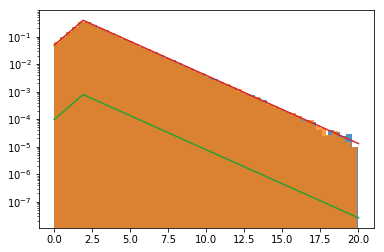

In [76]:
plt.hist(z_sampled, bins=50, density=True, alpha=0.8)
plt.hist(z_sampled2, bins=50, density=True, alpha=0.8)
plt.plot(z, z_pdf_normed)
plt.plot(z, z_pdf_normed2)
plt.yscale('log')

In [28]:
%timeit z_sampled = sample_from(z, z_pdf, 10000, True)

62 ms ± 3.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit z_sampled2 = np.random.choice(z, size=10000, p=z_pdf_normed)

868 µs ± 8.94 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [77]:
def xBtild(x, ktild, alpha, beta, spec='Band'):
    """
        Unitless spectral shape (of N_E, i.e. photon spectrum in ph/cm2/s)
    """

    if isinstance(x, np.ndarray):
        xBtild = np.zeros(len(x))
        for i in range(len(x)):
            if spec == 'Band':
                x_c = (beta - alpha) / (2.0 - alpha)
                if(x[i] < x_c):
                    xBtild[i] = ktild * x[i]**(1.0-alpha) * np.exp((alpha - 2.0) * x[i])
                elif (x[i] > x_c):
                    xBtild[i] = ktild * x[i]**(1.0-beta) * np.exp(alpha - beta) * x_c**(beta - alpha)
                else:
                    xBtild[i] = ktild * x_c**(1.0-alpha) * np.exp(alpha - beta)

            elif spec == 'BPL':
                ktild = (2.0-alpha) * (beta-2.0) / (beta-alpha)
                if(x[i] < 1.0):
                    xBtild[i] = ktild * x[i]**(1.-alpha)
                elif(x[i] > 1.0):
                    xBtild[i] = ktild * x[i]**(1.-beta)
                else:
                    xBtild[i] = ktild
    else:
        if spec == 'Band':
            x_c = (beta - alpha) / (2.0 - alpha)
            if(x < x_c):
                xBtild = ktild * x**(1.0-alpha) * np.exp((alpha - 2.0) * x)
            elif (x > x_c):
                xBtild = ktild * x**(1.0-beta) * np.exp(alpha - beta) * x_c**(beta - alpha)
            else:
                xBtild = ktild * x_c**(1.0-alpha) * np.exp(alpha - beta)
        elif spec == 'BPL':
            ktild = (2.0-alpha) * (beta-2.0) / (beta-alpha)
            if(x < 1.0):
                xBtild = ktild * x**(1.-alpha)
            elif(x > 1.0):
                xBtild = ktild * x**(1.-beta)
            else:
                xBtild = ktild

    return xBtild

In [83]:
def xBtild2(x, ktild, alpha, beta, spec='Band'):
    """
        Unitless spectral shape (of N_E, i.e. photon spectrum in ph/cm2/s)
    """

    if isinstance(x, np.ndarray):
        if spec == 'Band':
            x_c = (beta - alpha) / (2.0 - alpha)
            xBtild = ktild * x**(1.0-alpha) * np.exp((alpha - 2.0) * x)
            w = np.where(x > x_c)[0]
            xBtild[w] = ktild * x[w]**(1.0-beta) * np.exp(alpha - beta) * x_c**(beta - alpha)
        elif spec == 'BPL':
            print('ktild in:',ktild)
            ktild = (2.0-alpha) * (beta-2.0) / (beta-alpha)
            print('ktild comp:',ktild)
            xBtild = ktild * x**(1.-alpha)
            w = np.where(x > 1.0)[0]
            xBtild[w] = ktild * x[w]**(1.-beta)
            
        else:
            raise IOError
    
    else:
        if spec == 'Band':
            x_c = (beta - alpha) / (2.0 - alpha)
            if(x <= x_c):
                xBtild = ktild * x**(1.0-alpha) * np.exp((alpha - 2.0) * x)
            elif (x > x_c):
                xBtild = ktild * x**(1.0-beta) * np.exp(alpha - beta) * x_c**(beta - alpha)

        elif spec == 'BPL':
            ktild = (2.0-alpha) * (beta-2.0) / (beta-alpha)
            if(x <= 1.0):
                xBtild = ktild * x**(1.-alpha)
            elif(x > 1.0):
                xBtild = ktild * x**(1.-beta)

    return xBtild

In [78]:
%timeit xBtild(np.logspace(-1,2,100),ktild=1.1476101551496523,alpha=0.6,beta=2.5)

208 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [80]:
%timeit xBtild2(np.logspace(-1,2,100),ktild=1.1476101551496523,alpha=0.6,beta=2.5)

42.1 µs ± 4.88 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [84]:
aa = xBtild2(np.logspace(-1,2,100),ktild=1.1476101551496523,alpha=0.6,beta=2.5, spec='BPL')

ktild in: 1.1476101551496523
ktild comp: 0.3684210526315789


In [85]:
np.logspace(-1,2,100).ndim

1

In [92]:
NGRB = 2
x = np.zeros((NGRB,3))
x[0] = np.arange(len(x[0]))
x[1] = 7+np.arange(len(x[1]))
x

array([[0., 1., 2.],
       [7., 8., 9.]])

In [94]:
alpha = np.array([0.5,0.8])
beta  = np.array([2.5,1.8])
ktild = np.array([1.1,0.7])
x_c = (beta - alpha) / (2.0 - alpha)
x_c

array([1.33333333, 0.83333333])

In [107]:
import scipy as sp
import scipy.integrate as integrate

In [104]:
xmin = (1.+2)*50/600
xmax = (1.+2)*300/600
x = np.logspace(np.log10(xmin), np.log10(xmax), 100)

In [119]:
B = integrate.simps(xBtild2(x, 1.148, 0.6, 2.5), x, axis=0)
B2 = integrate.cumtrapz(xBtild2(x, 1.148, 0.6, 2.5), x, axis=0)
B3 = integrate.trapz(xBtild2(x, 1.148, 0.6, 2.5), x, axis=0)
print((B-B3)/B3 * 100)

-0.00100124363633083


In [109]:
%timeit B = integrate.simps(xBtild2(x, 1.148, 0.6, 2.5), x, axis=0)

73.9 µs ± 2.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [111]:
%timeit B = integrate.cumtrapz(xBtild2(x, 1.148, 0.6, 2.5), x, axis=0)

25.2 µs ± 1.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [117]:
%timeit B = integrate.trapz(xBtild2(x, 1.148, 0.6, 2.5), x, axis=0)

24.8 µs ± 1.59 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [122]:
import time
import datetime

In [126]:
datetime.datetime.now().strftime('%y%m%d')

'190322'

In [136]:
x = np.linspace(0, 100, 101) -1

10.0 11


In [142]:
def where_value(value, array):
    """
        Function that returns the indice of a value in a !!! sorted !!! array.
        Essentially a dichotomy (bisection in english).
        It returns indice for which :
        array[indice] < value <=  array[indice+1]
        Returns -1 if value is out of bounds.

        Parameters :
        ------------
        value : [float]
            Value to find in the array.

        array : [array]
            Array in which to look.

        Returns :
        ---------
        indice : [int]
            The indice where the value was found in the array.
    """
    imin = 0
    imax = len(array)-1
    if(value < array[0] or value > array[-1]):
        print("[Warning] in where_value : value is out of range of the array, indice returned : -1")
        indice = -1
    else:
        jj = 0
        while True:
            if (jj > 100000):
                print("[Error] in where_value : looping over 100000 times, aborting.")
                print("[Error] in where_value : imax, imin, j = ", imax, imin, j)
                break
            j = int((imin + imax)/2)
            jj += 1
            if(value > array[j]):
                imin = j+1
            elif(value < array[j-1]):
                imax = j
            else:
                break
        indice = j-1

    return indice


In [148]:
i2 = where_value(9.4, x)
print(x[i2],i2)
i = x.searchsorted(9.4)
print(x[i],i)

9.0 10
10.0 11


In [149]:
%timeit i2 = where_value(9.4, x)

3.26 µs ± 150 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [150]:
%timeit i = x.searchsorted(9.4)

537 ns ± 7.75 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [151]:
xmin = np.array([3,2,4,1])
xmax = np.array([5,6,5,4])

In [162]:
x = np.linspace(xmin,xmax, 10, axis=-1)

In [164]:
x[0]

array([3.        , 3.22222222, 3.44444444, 3.66666667, 3.88888889,
       4.11111111, 4.33333333, 4.55555556, 4.77777778, 5.        ])

In [161]:
np.linspace??